In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import fftconvolve
import dask.array as da
from pulse_pair_doppler import pulse_pair_doppler

In [2]:
model = pulse_pair_doppler(
    t_pulse=1.15e-4,                   # s
    t_receive=20e-4,                # s 
    t_interpulse=0*1e-4,              # s
    # n_reflectors=4,            # -    TODO why does this number increase error?
    # temporal_decorr = 0.98,
    n_pulses=2,                     # -
    n_bursts=35,                    # -
    bandwidth=1e6,                  # hz
    baseband=0,                     # hz   TODO why does this number increase error?
    oversample_retriev=1,           # -    TODO why does this number increase error?
    range_cell_avg_factor=1,        # -
    range_cell_size_frac_pulse=1,   # -
    seed=12,                         # -
)

model.chirp(centre_around_baseband=True).pulse_pairs()

pulse_pair_doppler(t_pulse=0.000115, t_receive=0.002, t_interpulse=0.0, n_pulses=2, n_bursts=35, bandwidth=1000000.0, baseband=0, seed=12, temporal_decorr=False, n_reflectors=None, oversample_retriev=1, range_cell_avg_factor=1, range_cell_size_frac_pulse=1)

In [3]:
# TODO fix chunk size at start
# TODO Have reflection be sampled at same temporal resolution as pulse
# TODO calculate pulses individually or somehow calculate reflection per pulse after groupby
# TODO calculate range and distance not from x and y, but of x and y and some array that adds a constant small offset per cell (mimicking that scatterers are not equally spaced)
# NOTE flox installed in environment to speed up groupby

In [4]:
c = 3e8
res_az = 150 # m   TODO find resolution along azimuth
res_rg = 150 # m   TODO make function of bandwith
n_scatterers_per_cell = 1
extent_rg = 600e3 #600e3 # m 
extent_az = 150e3 # m
incidence_min = 29 # deg
x0, y0, z0 = 0, 0, 700e3 # m azimuth, range, altitude satellite
PRF = 5 # / s
distance_satellite = 25e3 # m 
vy_satellite, vx_satellite, vz_satellite = 0, 6800, 0 # m /s
n_bursts = int(np.floor(distance_satellite / vx_satellite * PRF))

n_scatterers_az = int(extent_az / res_az * n_scatterers_per_cell)
n_scatterers_rg = int(extent_rg / res_rg * n_scatterers_per_cell)

min_rg = np.tan(np.deg2rad(incidence_min))*z0
max_rg = min_rg + extent_rg
min_az, max_az = -extent_az/2, extent_az /2

seed = 42
np.random.seed(seed)
chunk_az = 100
chunk_rg = 100
chunk_time_slow = 1
chunk_pulse_time = -1

rg_extent = da.from_array(np.linspace(start=min_rg, stop=max_rg, num=n_scatterers_rg), chunks = (chunk_rg))
az_extent = da.from_array(np.linspace(start=min_az, stop=max_az, num=n_scatterers_az), chunks = (chunk_az))

rg, az = np.meshgrid(rg_extent, az_extent)

In [5]:
time_slow = np.linspace(start=0, stop=n_bursts/PRF ,num=n_bursts)

# TODO undo
amplitude = da.from_array(np.random.rayleigh(scale=1, size=(rg.shape[0], rg.shape[1],  len(time_slow))), chunks=(chunk_az, chunk_rg, chunk_time_slow))
# t = np.zeros(shape=(rg.shape[0], rg.shape[1],  len(time_slow)))
# t[0, 2000, :] = 1
# t[0, 1500, :] = 1
# t[0, 1000, :] = 1
# amplitude = da.from_array(t, chunks=(chunk_az, chunk_rg, chunk_time_slow))


# TODO add offset again
spatial_grid_offset_rg = da.from_array(np.random.uniform(low=-res_rg/2, high =res_rg/2, size= (rg.shape[0], rg.shape[1])), chunks=(chunk_az, chunk_rg))
spatial_grid_offset_az = da.from_array(np.random.uniform(low=-res_az/2, high =res_az/2, size= (rg.shape[0], rg.shape[1])), chunks=(chunk_az, chunk_rg))
# spatial_grid_offset_rg = np.zeros_like(rg)
# spatial_grid_offset_az = np.zeros_like(az)


uniform_phase = da.from_array(np.random.rand(amplitude.size).reshape(amplitude.shape), chunks = (chunk_az, chunk_rg, chunk_time_slow))
scatter_phase = np.exp(1j*uniform_phase*2*np.pi)
velocity = np.ones_like(amplitude)

x_sat = x0 + time_slow * vx_satellite
y_sat = y0 + time_slow * vy_satellite
z_sat = z0 + time_slow * vz_satellite

In [6]:
ds = xr.Dataset(
    data_vars=dict(
        amplitude=(["x", "y", "time_slow"], amplitude), 
        spatial_grid_offset_rg=(["x", "y"], spatial_grid_offset_rg), 
        spatial_grid_offset_az=(["x", "y"], spatial_grid_offset_az), 
        velocity=(["x", "y", "time_slow"], velocity),
        reflector=(["x", "y", "time_slow"], amplitude * scatter_phase), 
        scatter_phase=(["x", "y", "time_slow"], scatter_phase),
        # TODO add beam pattern 
        # TODO add realistic gradient based on CMOD
        x_sat=(["time_slow"], x_sat),
        y_sat=(["time_slow"], y_sat),
        z_sat=(["time_slow"], z_sat),

    ),
    coords=dict(
        rg=(["x", "y"], rg),
        az=(["x", "y"], az),
        time_slow=(["time_slow"], time_slow),
    ),
    attrs=dict(description="Simulated surface", 
               vx_sat=vx_satellite, 
))
ds

<xarray.Dataset>
Dimensions:                 (x: 1000, y: 4000, time_slow: 18)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118 0.4235 ... 3.388 3.6
Dimensions without coordinates: x, y
Data variables:
    amplitude               (x, y, time_slow) float64 dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    velocity                (x, y, time_slow) float64 dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    reflector               (x, y, time_slow) complex128 dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex128 dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    x_sat                   (time_slow) float64 0.0 1.44e+03 ... 2.448e+04
    y_sat                   (time_slow) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    z_sat                   (time_slow) float64 7e+05 7e+05 ... 7e+05 7e+05
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [7]:
def calculate_distance(x, y, x0=0 , y0=0, x_offset=0, y_offset=0):
    return np.sqrt((x - x0 + x_offset) ** 2 + (y - y0 + y_offset) ** 2)

ds['d_ground'] = calculate_distance(ds['az'], ds['rg'], ds['x_sat'], ds['y_sat'], ds['spatial_grid_offset_az'], ds['spatial_grid_offset_rg'])
ds['R'] = calculate_distance(ds['d_ground'], ds['z_sat'])

ds['travel_time'] = 2*ds['R']/c # times 2 for two way travel time
t_min = ds.travel_time.min().values*1
t_max = ds.travel_time.max().values*1 + model.t_pulse
n_reflection_samples = int(np.ceil((t_max - t_min)*model.fs)) * model.oversample_retriev
fast_time_bins = np.linspace(t_min, t_max, n_reflection_samples)

bin_offset = da.digitize(ds["travel_time"].data, fast_time_bins, right = True) # TODO this can be made a finer resolution
ds['bin_offset'] = (['x', 'y', 'time_slow'], bin_offset)

ds

<xarray.Dataset>
Dimensions:                 (x: 1000, y: 4000, time_slow: 18)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118 0.4235 ... 3.388 3.6
Dimensions without coordinates: x, y
Data variables: (12/13)
    amplitude               (x, y, time_slow) float64 dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    velocity                (x, y, time_slow) float64 dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    reflector               (x, y, time_slow) complex128 dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex128 dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    ...                      ...
    y_sat                   (time_slow) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    z_sat                   (time_slow) float64 7e+05 7e+05 ... 7e+05 7e+05
    d_ground                (x, y, time_slow) float64 dask.array<chunksize=(100, 100, 18), meta=np.ndarray>
    R                       (x, y, time_slow) float64 dask.array<chunksize=(100, 100, 18), meta=np.ndarray>
    travel_time             (x, y, time_slow) float64 dask.array<chunksize=(100, 100, 18), meta=np.ndarray>
    bin_offset              (x, y, time_slow) int64 dask.array<chunksize=(100, 100, 18), meta=np.ndarray>
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [8]:
# TODO this should be done per slow time
ds_subset = ds[['bin_offset', 'reflector']].isel(time_slow=0)
surface = ds_subset.groupby_bins(group = ds_subset['bin_offset'], bins=np.arange(0, len(fast_time_bins))).sum()

In [9]:
reflection = surface.reflector.values
reflection = np.where(np.isfinite(reflection), reflection, 0)
model.reflections = fftconvolve(reflection, model.signal, mode = 'valid')
model.pulse_compress(window_function=False)
model.delayed_autocorrelation()
model.phase_difference()

Autocorrelation cell: 100%|██████████| 21/21 [00:00<00:00, 10073.24it/s]


pulse_pair_doppler(t_pulse=0.000115, t_receive=0.002, t_interpulse=0.0, n_pulses=2, n_bursts=35, bandwidth=1000000.0, baseband=0, seed=12, temporal_decorr=False, n_reflectors=None, oversample_retriev=1, range_cell_avg_factor=1, range_cell_size_frac_pulse=1)

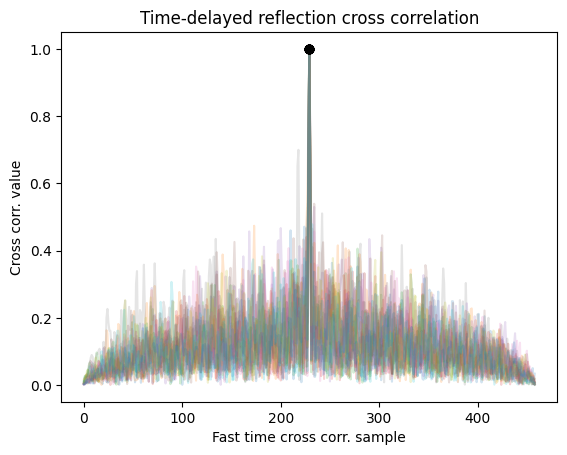

In [10]:
sig = abs(model.corr.T)
sig /= np.max(sig, axis = 0)
peaks = np.argmax(sig, axis = 0)

plt.figure()
plt.title("Time-delayed reflection cross correlation"); plt.xlabel("Fast time cross corr. sample"); plt.ylabel("Cross corr. value"); 
plt.plot(sig, alpha = 0.2, zorder = 1)
plt.scatter(peaks, sig[peaks, np.arange(len(model.corr))], c = 'k', zorder =2)

In [11]:
if model.n_reflectors is not None:
    # arb_cross_corr_limit = np.min(np.sort(np.max(sig, axis = 0), axis=0)[-model.n_reflectors:])
    # phase_diff = model.phase_diff_avg_rg[sig.max(axis= 0) >= arb_cross_corr_limit]
    wvc_cell = np.unique(np.where(abs(model.surface) > 0)[0] // len(model.pulse) - 2 )
    wvc_cell = wvc_cell[(wvc_cell>=0) & (wvc_cell< len(model.phase_diff_avg_rg))]
    phase_diff = model.phase_diff_avg_rg[wvc_cell]
    print(f"WVC: {wvc_cell}, \nwith phase diff.: \n{phase_diff}")
else:
    phase_diff = model.phase_diff_avg_rg

phase_diff_rmse = np.sqrt(np.mean(phase_diff**2))

c = 3e8 # m/s
Lambda = 0.05 # c/f # m
t_delta = model.t_pulse + model.t_interpulse

LoS_velocity_phase = phase_diff * Lambda / (2*np.pi * t_delta)
LoS_velocity_phase_rmse = phase_diff_rmse * Lambda / (2*np.pi * t_delta)

print(f"\n RMSE phase error of: {phase_diff_rmse:.4f} rad, which is equal to {LoS_velocity_phase_rmse:.3f} m/s ")


 RMSE phase error of: 0.1066 rad, which is equal to 7.378 m/s 


In [29]:
def coherence_calc(signal1, signal2):

    # Yields similar performance as the mean output from scipy.signal.coherence using a 'hann' window

    # Compute the cross-power spectral density (CSD)
    csd = np.mean(signal1 * np.conj(signal2))

    # Compute the power spectral density (PSD) for each signal
    psd_signal1 = np.mean(np.abs(signal1)**2)
    psd_signal2 = np.mean(np.abs(signal2)**2)

    # Calculate the coherence using the CSD and PSD values
    coherence = np.abs(csd)**2 / (psd_signal1 * psd_signal2)

    return coherence


gamma = 0.8
reflection_decorr = gamma * reflection + np.sqrt(1-(gamma)**2) *np.random.rayleigh(1, len(reflection))*np.exp(-1j*2*np.pi*np.random.uniform(0, 1, size = len(reflection)))
coherence_calc(reflection, reflection_decorr)

0.9991749625172558

In [58]:
s1 = np.random.rayleigh(1, len(reflection))*np.exp(-1j*2*np.pi*np.random.uniform(0, 1, size = len(reflection)))
s2 = np.random.rayleigh(1, len(reflection))*np.exp(-1j*2*np.pi*np.random.uniform(0, 1, size = len(reflection)))

s12 = gamma*s1 + np.sqrt(1-abs(gamma)**2)* s2

coherence_calc(s1, s12)

0.6416657628987257

In [16]:
new_dtype = 'float32'

# Create a new Dataset with the modified datatypes
ds = xr.Dataset({
    k: (v.astype('complex64') if v.dtype == 'complex128' else v.astype(new_dtype))
    for k, v in ds.data_vars.items()
})

ds = ds.isel(time_slow=range(0,2))#, y=range(0,12000))#, x=range(0,100))
ds

<xarray.Dataset>
Dimensions:                 (x: 1, y: 4000, time_slow: 2, pulse_time: 1150)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118
Dimensions without coordinates: x, y, pulse_time
Data variables:
    amplitude               (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float32 dask.array<chunksize=(1, 50), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float32 dask.array<chunksize=(1, 50), meta=np.ndarray>
    velocity                (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    x_sat                   (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    y_sat                   (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    z_sat                   (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    d_ground                (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    R                       (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    fast_time               (x, y, time_slow, pulse_time) float32 dask.array<chunksize=(1, 50, 1, 1150), meta=np.ndarray>
    reflection              (x, y, time_slow, pulse_time) complex64 dask.array<chunksize=(1, 50, 1, 1150), meta=np.ndarray>

In [17]:
import dask.distributed
client = dask.distributed.Client()
client

In [20]:
# def searchsort_custom(da, bins):
#     return np.searchsorted(bins, da)

# ds["index_digi"] = ds[["fast_time"]].apply(searchsort_custom, bins=bins).fast_time.astype('int32').chunk({'x': chunk_az, 'y': chunk_rg, 'time_slow': chunk_time_slow, 'pulse_time':chunk_pulse_time})